# **Data science workshop project**
**Team:** Elad, Tzach, Oz, Eva

**Problem:** The predictors of in-hospital mortality for admitted patients remain poorly characterized.

**Goal of the project**: We aimed to develop and validate a prediction model for all-cause in-hospital mortality among admitted patients.


## Introduction: understand and clean the dataset

We chose a dataset that revolves around the world of medicine (specifically all-cause in-hospital mortality among admitted patients).

This decision was based on us wanting to make the project about a subject that is impactful and important,
as well as enlightening so we could learn new things about health and hospital statistics.

In [6]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [7]:
#data processing
import pandas as pd
import numpy as np

#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#Machine learning library
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics
from xgboost import plot_importance
from sklearn.utils import resample


from Model.ModelModule import DSWorkshopModel  # separate python file which hold data and run models

In [8]:
complete_data = pd.read_csv('data/dataset.csv') #load the dataset

In [9]:
complete_data.head() #beginning of the dataset

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0


In [10]:
complete_data.shape   #dataset sizes: 85 columns and 91713 rows/patients in the original dataset

(91713, 85)

In [11]:
#column / features and data types
complete_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

## Labels for prediction

Here we'll present some info and the distribution of the labels in our chosen dataset.

In [12]:
complete_data["hospital_death"].value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

In [13]:
class_prediction = "hospital_death" # Label

([<matplotlib.patches.Wedge at 0x1da33a7ab20>,
 [Text(-1.0598172020063896, 0.294597179774939, '0'),
  Text(1.0598172295885635, -0.2945970805476902, '1')],
 [Text(-0.5780821101853033, 0.16068937078633036, '91.4%'),
  Text(0.5780821252301255, -0.16068931666237643, '8.6%')])

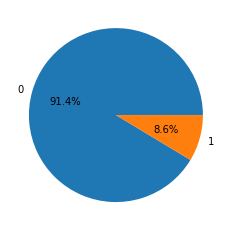

In [14]:
unique_labels = np.unique(complete_data[class_prediction])
plt.pie(np.array([len(complete_data[complete_data[class_prediction]==label]) for label in unique_labels ]), labels = list(unique_labels), autopct='%1.1f%%')

As you can see, the contrast between the distribution of the two label classes is exceptionally large, with the label '1' being far less common.

Due to that, it will be a challenge for the model to predict the label '1', which represnts cases that ended with patients' death.

Another challenge we face is keeping the model from being biased, since most of the data is labeled with '0' which will cause the model to easily predict this label, but not the other.

## Features

Here we'll separate our features to their types: numerical, categorical and binary - since each type needs a different treatment regarding filling missing values, converting to one-hot encoding, etc.

In [15]:
numerical_features = ["age", "bmi","height", "weight", 
                      "pre_icu_los_days", "gcs_eyes_apache","apache_2_diagnosis",
                      "gcs_motor_apache", "gcs_verbal_apache", "heart_rate_apache",
                     "map_apache", "resprate_apache", "temp_apache", "d1_diasbp_max",
                      "d1_diasbp_min","d1_diasbp_noninvasive_max", "d1_diasbp_noninvasive_min",
                      "d1_heartrate_max", "d1_heartrate_min", "d1_mbp_max", "d1_mbp_min", 
                      "d1_mbp_noninvasive_max", "d1_mbp_noninvasive_min", "d1_resprate_max", "d1_resprate_min",
                      "d1_spo2_max", "d1_spo2_min", "d1_sysbp_max", "d1_sysbp_min",
                      "d1_sysbp_noninvasive_max", "d1_sysbp_noninvasive_min", "d1_temp_max", "d1_temp_min",
                      "h1_diasbp_max", "h1_diasbp_min", "h1_diasbp_noninvasive_max", "h1_diasbp_noninvasive_min",
                      "h1_heartrate_max", "h1_heartrate_min", "h1_mbp_max", "h1_mbp_min",
                      "h1_mbp_noninvasive_max", "h1_mbp_noninvasive_min", "h1_resprate_max", "h1_resprate_min",
                      "h1_spo2_max", "h1_spo2_min", "h1_sysbp_max", "h1_sysbp_min",
                      "h1_sysbp_noninvasive_max", "h1_sysbp_noninvasive_min", "d1_glucose_max", "d1_glucose_min",
                      "d1_potassium_max", "d1_potassium_min", "apache_4a_hospital_death_prob", "apache_4a_icu_death_prob",
                      "apache_3j_diagnosis"]

categorial_features = ["hospital_id", "ethnicity", "gender", "icu_admit_source", "apache_3j_bodysystem", "apache_2_bodysystem", "icu_stay_type", "icu_type"]

binary_features = ["arf_apache", "gcs_unable_apache", "intubated_apache", 
                   "ventilated_apache", "elective_surgery", "apache_post_operative",
                   "aids", "cirrhosis", "diabetes_mellitus", "hepatic_failure", "immunosuppression",
                   "leukemia", "lymphoma", "solid_tumor_with_metastasis"]

### Value Histograms for Categorical Variables (via Pandas and Matplotlib)

Here we'll present some of the categorical data we have, which features interesting details about the patients.

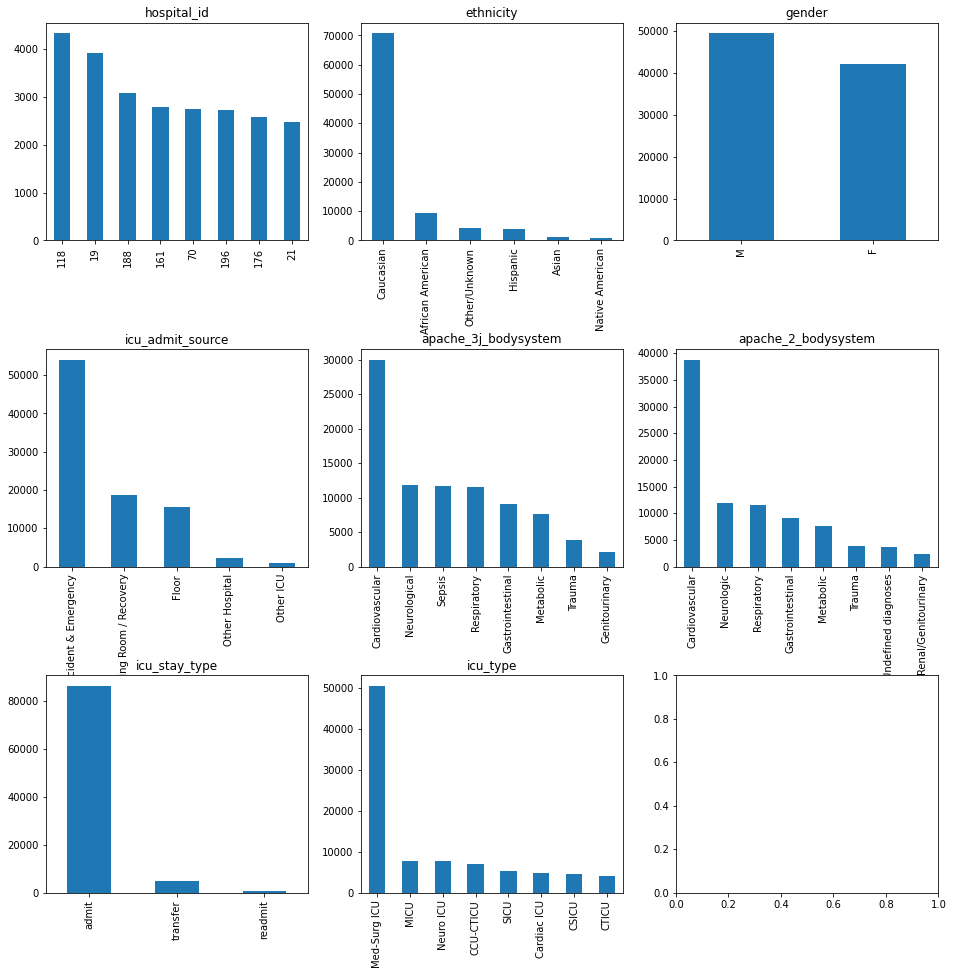

In [16]:
#generate a figures grid:
fig, axes = plt.subplots(3,3,figsize=(16,16))
fig.subplots_adjust(hspace=0.5)

#we will create a histogram for each categorical attribute
n=len(categorial_features)
num_rows = 3
max_bars = 8

for i,variable in enumerate(categorial_features):
    #calculate the current place on the grid
    r=int(i/num_rows)
    c=i%num_rows
    
    #create the "value counts" for the first <max_bars> categories:
    u=min(complete_data[variable].nunique(),max_bars)
    vc = complete_data[variable].value_counts()[:u]
    
    # plot a bar chart using Pandas
    vc.plot(kind='bar',ax=axes[r,c],title=variable)


correlation?

## Influence of the age of the patient on the hospital death

We noticed an interesting correlation between the age of the patient to the chance of the patient's death:

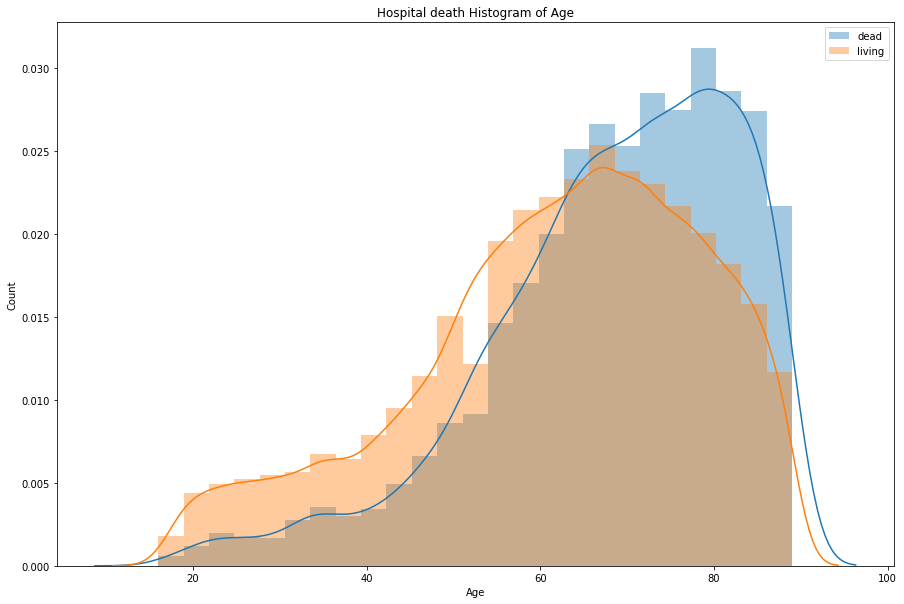

In [17]:
dead_patient = complete_data[complete_data["hospital_death"] == 1]
living_patient =  complete_data[complete_data["hospital_death"] == 0]

fig,ax=plt.subplots(figsize=(15,10))

#create two histograms
sns.distplot(dead_patient.age, bins = 25, kde = True, label = "dead",ax=ax)
sns.distplot(living_patient.age, bins = 25, kde = True, label = "living",ax=ax)

plt.title('Hospital death Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(loc="upper right")

As you can see, the chance of a patient to live drastically lowers after age 70, which makes sense because the body and its immune system are much more frail and weak.

## Understand binary features

Here we'll present some of the binary features in the data.

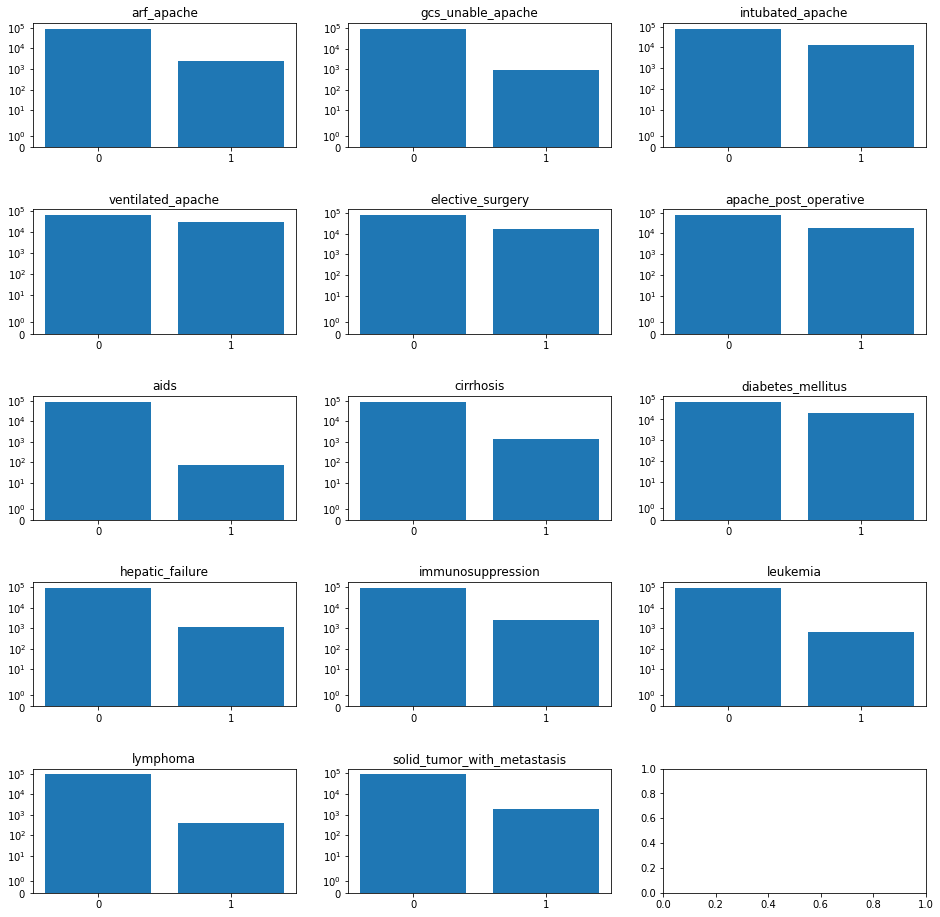

In [18]:
fig, axes = plt.subplots(5,3,figsize=(16,16))
fig.subplots_adjust(hspace=0.5)

#we will create a histogram for each categorical attribute
n=len(binary_features)
num_rows = 3
max_bars = 5

for i,variable in enumerate(binary_features):
    #calculate the current place on the grid
    r=int(i/num_rows)
    c=i%num_rows
    
    #create the "value counts" for the first <max_bars> categories:
    u=min(complete_data[variable].nunique(),max_bars)
    vc = complete_data[variable].value_counts()[:u]

    # plot a bar chart using Pandas
    #vc.plot(kind='bar',ax=axes[r,c],title=variable)
    axes[r, c].set_yscale('symlog')
    axes[r, c].bar(range(len(vc)), vc)
    axes[r, c].set_title(variable)
    axes[r, c].locator_params(axis='x', nbins=1)

plt.show()

Since the graphs has shown major difference between the two categories, we changed the scale of y to a symmetric log.

In [ ]:
sns.heatmap(complete_data[numerical_features], annot=True)


Most of values are 0 so we will change the representation:
    fill missing values with 0 
    add column which tell when this feature is missing

## Check number of missing values

The problem of missing values occurs in many datasets, this one included. Dealing with it is important since it can affect the accuracy of the model, sometimes by a considerable amount.

Before we're trying to solve it, let's analyze it first and check how many missing values we have.

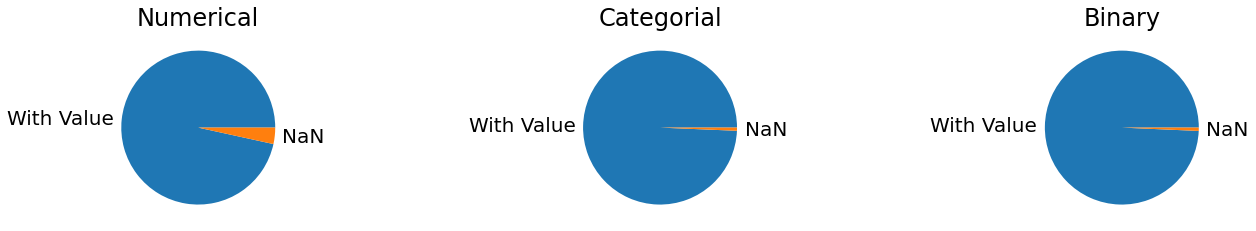

In [78]:
pd.set_option('display.max_rows', None)
def NaN_info(df):
    global null_view
    try:
        null_view = df[[col for col in df.columns if df[col].isna().sum() > 0]].isna().sum()
    except:
        return null_view
    return null_view.sum()

labels = ["With Value", "NaN"]
plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 20})

# Numerical
nan_values = NaN_info(complete_data[numerical_features])
total_values = complete_data[numerical_features].shape[0] * complete_data[numerical_features].shape[1]
missing_percent = np.array([total_values - nan_values, nan_values])

plt.subplot(1, 5, 1)
plt.title("Numerical")
plt.pie(missing_percent, labels=labels)

# Categorial
nan_values = NaN_info(complete_data[categorial_features])
total_values = complete_data[categorial_features].shape[0] * complete_data[categorial_features].shape[1]
missing_percent = np.array([total_values - nan_values, nan_values])

plt.subplot(1, 5, 3)
plt.title("Categorial")
plt.pie(missing_percent, labels=labels)

# Binary
nan_values = NaN_info(complete_data[binary_features])
total_values = complete_data[binary_features].shape[0] * complete_data[binary_features].shape[1]
missing_percent = np.array([total_values - nan_values, nan_values])

plt.subplot(1, 5, 5)
plt.title("Binary")
plt.pie(missing_percent, labels=labels)


plt.show()

You can see here that although it seems minor, the percentage of the missing values in all data types, especially the numerical features - is not something that should be disregarded.

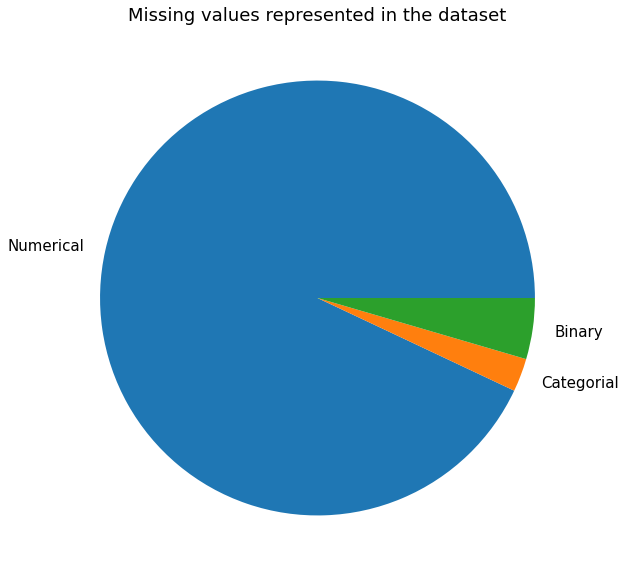

In [83]:
plt.rcParams.update({'font.size': 15})
missing_values_in_data = np.array([NaN_info(complete_data[numerical_features]), NaN_info(complete_data[categorial_features]), NaN_info(complete_data[binary_features])])
labels = ["Numerical", "Categorial", "Binary"]
plt.figure(figsize=(10,10))
plt.pie(missing_values_in_data, labels=labels)
plt.title("Missing values represented in the dataset")
plt.show()

Out of all the missing values in the dataset, we can see that the most are from the numerical features.

Overall, we have quite the amount of missing values in our dataset. Now we'll see how to deal with the problem.

## Methods for dataset

Since the missing values are from different types, we can't fill them all in the same method. Each type will use a different way to deal with the missing values.

In [ ]:
def getBasicDataset(): #return dataset without empty column, shuffled and with onehot encoding
    complete_data = pd.read_csv('dataset.csv') #load the dataset
    complete_data.drop(complete_data.columns[[0,1,83]], axis=1, inplace=True) #delete feature 83
    complete_data = complete_data.sample(frac=1) #shuffle
    complete_data = pd.get_dummies(complete_data,columns=categorial_features) #one hot encoding
    return complete_data

After learning about different filling methods for numerical missing values from Tzach's previous project (Also a course about tabular data science) we have decided to fill each missing value with the mean average of each feature column, since this method has proven the best out of all the methods (For example, deleting rows, using KNN to predict the value, etc.)

In [ ]:
# Filling missing NUMERICAL values with mean
def fill_missing_num_values_with_mean(complete_data):
    for feature in numerical_features:
        if feature in complete_data.columns:
            mean_value = complete_data[feature].mean()
            complete_data[feature].fillna(value=mean_value, inplace=True)
    return complete_data

In [ ]:
def fill_missing_values_binary(df): 
    #add column for binary missing values
    binary_features_with_missing_values = df[binary_features].columns[df[binary_features].isnull().any()]
    for f in binary_features_with_missing_values:
        name = "missing " + f
        df[name] = (df[f].isnull()).astype(int) # add feature which tell when value is missing
    # change missing values to 0 in the original feature
    for f in binary_features:
        df[f] = df[f].fillna(0)
    return df

In [ ]:
feature_to_Nan=['h1_diasbp_noninvasive_max', 'temp_apache','h1_diasbp_noninvasive_min','age', 'd1_potassium_max', 'weight', 'h1_diasbp_min','h1_sysbp_min', 'd1_potassium_min','apache_2_diagnosis']

def addRows(df):
    fakeRowsIndex = []
    to_remove =[]
    deadRows = df[df['hospital_death'] == 1]
    for index, row in deadRows.iterrows():
        if row.isna().sum().sum() > 10:
            to_remove.append(index)
    deadRows = deadRows.drop(to_remove)
    pd.concat([deadRows]*4, ignore_index=True) #duplicate each row 4 times
    for f in feature_to_Nan:
        deadRows[f] = df[f].sample(frac=0.8)
    fakeRowsIndex = deadRows.index
    final_Df = pd.concat([df, deadRows], axis=0)
    return final_Df, fakeRowsIndex, deadRows


In [ ]:
def runModel(df):
    model = DSWorkshopModel(df)
    train_data = df.drop('hospital_death', axis=1)
    true_values = df.hospital_death
    x_train, x_test, y_train, y_test = train_test_split(train_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)
    model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
    model.train()
    return model

In [ ]:
def createBMI_cat(complete_data):
    bmi_cat = ['Severe Thinness', 'Moderate Thinness','Mild Thinness','Normal', 
           'Overweight','Obese l1',"Obese l2"," Obese l3","missing bmi 2"]
    category_bmi = pd.cut(complete_data['bmi'], bins=[0,16,17,18.5,25,30,35,40,80,100], labels=bmi_cat)
    complete_data.insert(9,'bmi group',category_bmi)
    complete_data.drop('bmi', inplace=True, axis=1)
    complete_data = pd.get_dummies(complete_data,columns=['bmi group'])
    complete_data.drop('bmi group_missing bmi 2', inplace=True, axis=1) 
    return complete_data

In [ ]:
def generate_gcs_score(row): #sum each component
    return row['gcs_motor_apache']+row['gcs_verbal_apache']+row['gcs_eyes_apache']

def dealWithGCS(df3):
    gcs_params = ['gcs_motor_apache', 'gcs_verbal_apache','gcs_eyes_apache']
    gcs_data = df3[gcs_params]
    df3['gcs_score']=df3.apply(generate_gcs_score,axis=1)
    gcs_cat = ['Severe', 'Moderate','Mild']
    category_gcs = pd.cut(df3['gcs_score'], bins=[3,8,12,15], 
                          labels=gcs_cat)
    df3.insert(3,'gcs group',category_gcs)
    df3 = pd.get_dummies(df3,columns=['gcs group'])
    df3 = df3.drop('gcs_score', axis=1)
    return df3

In [ ]:
from sklearn.metrics import confusion_matrix
def conf_matrix(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [ ]:
def resampleData(df):
    one_prediction = df[(df['hospital_death']==1)]
    zero_prediction = df[(df['hospital_death']==0)]
    upsample_df = resample(one_prediction, replace=True, n_samples= int(0.75*len(zero_prediction)), random_state=42)
    df = pd.concat([upsample_df, zero_prediction])
    return df

In [ ]:
def downsampleData(df):
    one_prediction = df[(df['hospital_death']==1)]
    zero_prediction = df[(df['hospital_death']==0)]
    downsample_df = resample(zero_prediction, replace=True, n_samples= int(1.2*len(one_prediction)), random_state=42)
    df = pd.concat([downsample_df, one_prediction])
    return df

## 1. Run Model on original dataset 
(We filled all missing values which are numerical with mean and add column which tell when data is missing), we also apply one hot encoding for original categorical features. 

In [ ]:
df1 = getBasicDataset()
df1 = fill_missing_num_values_with_mean(df1)
df1 = fill_missing_values_binary(df1)

In [ ]:
model = DSWorkshopModel(df1)

In [ ]:
# Preparing the data
train_data = df1.drop('hospital_death', axis=1)
true_values = df1.hospital_death
x_train, x_test, y_train, y_test = train_test_split(train_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)

In [ ]:
model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

In [ ]:
model.train()

In [ ]:
models_predictions, pred_results = model.test()

In [ ]:
print(pred_results)

          Method  Precision Score  Recall Score  F1 Score  \
0   RandomForest         0.727096      0.235629  0.355916   
1     ExtraTrees         0.770883      0.204043  0.322677   
2  XGBClassifier         0.670543      0.327858  0.440390   

   Unbalanced Accuracy Score  Balanced Accuracy Score  \
0                   0.926402                 0.613638   
1                   0.926075                 0.599158   
2                   0.928092                 0.656322   

   Positive Accuracy Score  Negative Accuracy Score Time Needed for Training  
0                  0.23563                  0.99165                   43.89s  
1                  0.20404                  0.99427                   56.21s  
2                  0.32786                  0.98479                   53.47s  


For original dataset, we have results of around:
- 70 % precision score
- 20 % recall
- 99 % accuracy for negative
- 33 % accuracy for positive

We will focus on the model using xgboost (classifier[2])

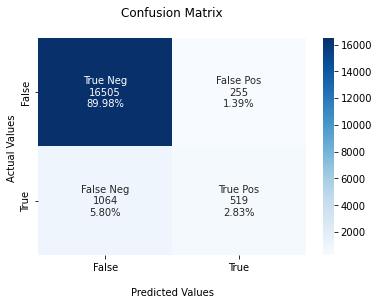

In [ ]:
cf_matrix = confusion_matrix(y_test.to_numpy(), models_predictions[-1])
conf_matrix(cf_matrix)

A true positive is an outcome where the model correctly predicts the positive class. Similarly, a true negative is an outcome where the model correctly predicts the negative class.

A false positive is an outcome where the model incorrectly predicts the positive class. And a false negative is an outcome where the model incorrectly predicts the negative class.

=> We can see that we need to reduce the amount of false negative: so we need to maybe improve feature which influence a lot on the result.

Let s try to check SHAP result to see feature importance

### Evaluation Plots

In [ ]:
y_true = y_test
xgb = model.get_models()[2] #xgboost
predicted_probs = xgb.predict_proba(x_test)
y_score = predicted_probs[:,1]

### precision recall curve

In [ ]:
def plotPR(precision, recall):
    plt.figure()
    plt.plot(recall, precision, label='PR curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall curve')
    plt.legend(loc='lower left')
    plt.show()
    

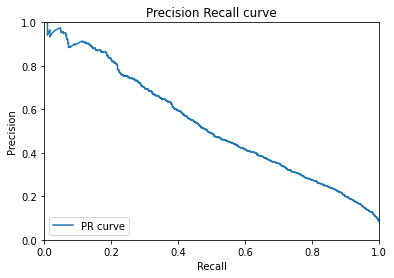

In [ ]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score, pos_label=1)
plotPR(precision, recall)

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

In [ ]:
### ROC curve

In [ ]:
def plotRoc(fpr, tpr, auc):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

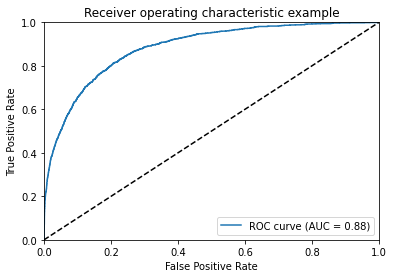

In [ ]:
auc = sklearn.metrics.roc_auc_score(y_true, y_score)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
plotRoc(fpr, tpr, auc)

When we need to check or visualize the performance of the multi-class classification problem, we use the AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve. It is one of the most important evaluation metrics for checking any classification model’s performance. 
It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. 

### Model Analysis for xgboost on original dataset with only filling missing values 

### SHAP

In [ ]:
import shap
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(train_data)
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

c:\Users\OZ HIZKIYA\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


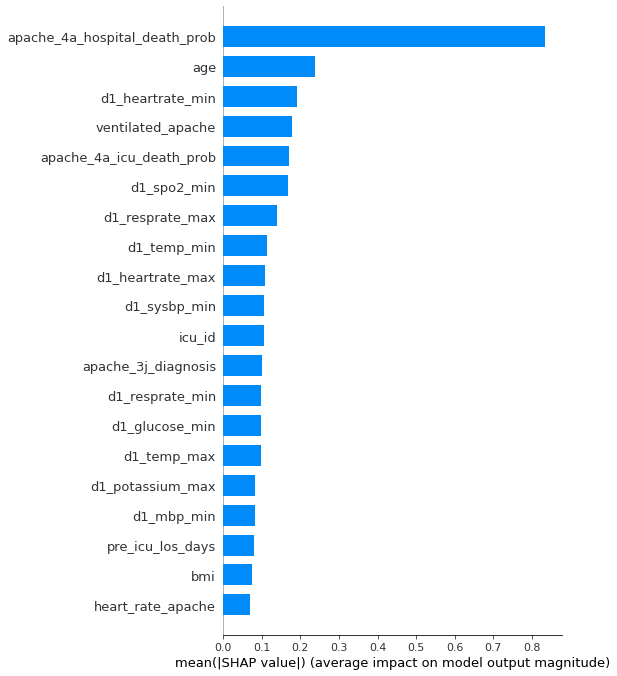

In [ ]:
shap.summary_plot(shap_values, train_data, plot_type="bar")

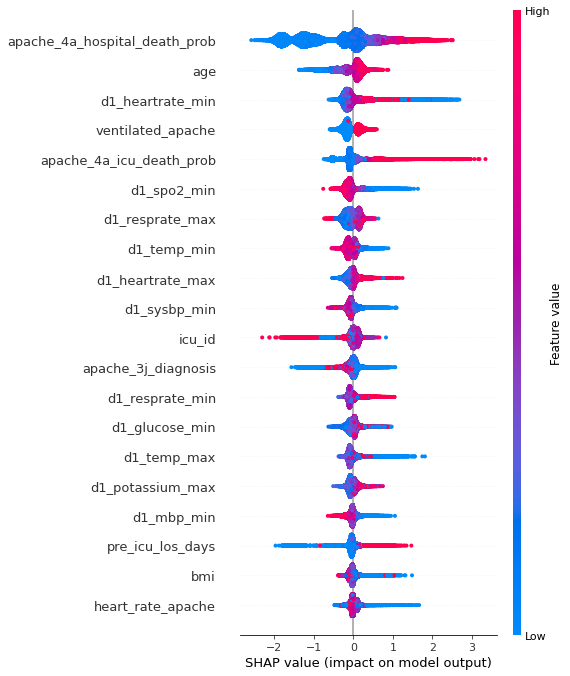

In [ ]:
shap.summary_plot(shap_values, train_data)

In [ ]:
def predict_fcn(x):
    return xgb.predict_proba(x)[:,1]

In [ ]:
background_data = shap.maskers.Independent(x_train, max_samples=100)
explainer = shap.Explainer(predict_fcn, background_data)

In [ ]:
shap_values_100 = explainer(x_test[:100])

Permutation explainer: 101it [00:51,  1.86it/s]                         


Explaining a prediction of "True" so hospital death in our case

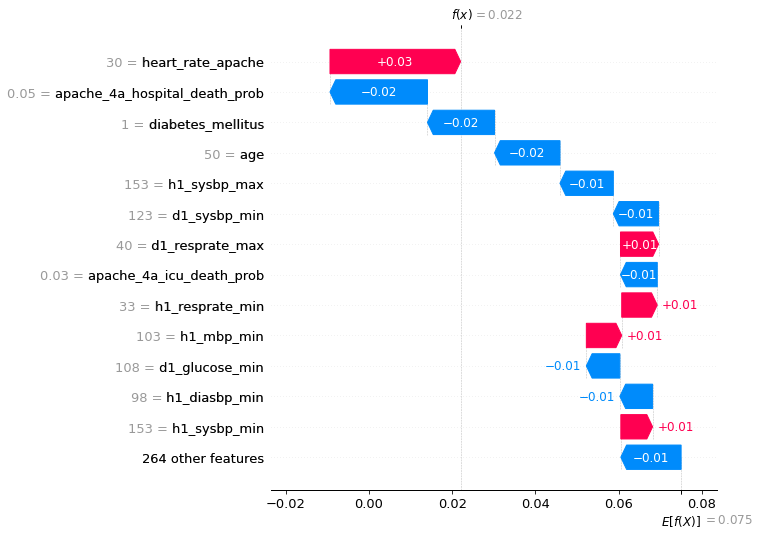

In [ ]:
shap.plots.waterfall(shap_values_100[2], max_display=14)

Summary of Shap values for all features across our 100 first predictions

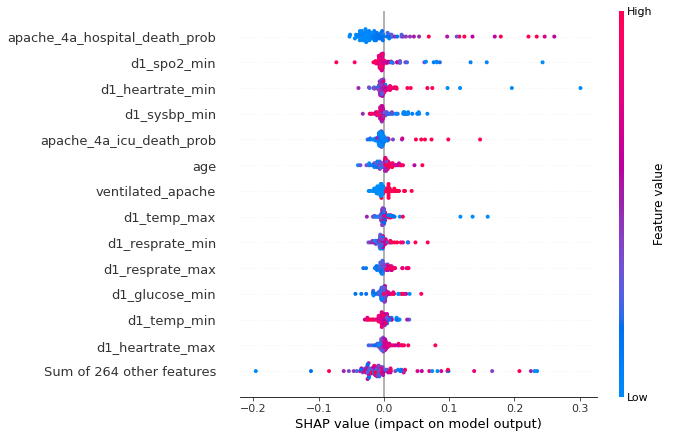

In [ ]:
shap.plots.beeswarm(shap_values_100, max_display=14)

In [ ]:
# try to identify ouliers and change the model base on this

## 2. Trying to add artificial data

          Method  Precision Score  Recall Score  F1 Score  \
0   RandomForest         0.915945      0.824886  0.868034   
1     ExtraTrees         0.956699      0.839831  0.894464   
2  XGBClassifier         0.858963      0.635153  0.730295   

   Unbalanced Accuracy Score  Balanced Accuracy Score  \
0                   0.961085                 0.905492   
1                   0.969251                 0.916425   
2                   0.927210                 0.808000   

   Positive Accuracy Score  Negative Accuracy Score Time Needed for Training  
0                  0.82489                  0.98610                    33.7s  
1                  0.83983                  0.99302                    35.8s  
2                  0.63515                  0.98085                   39.95s  


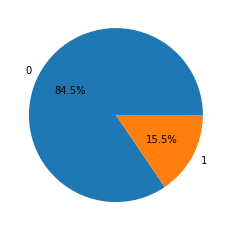

In [ ]:
df5 = getBasicDataset()

df5, fakeRowsIndex, fakeRows = addRows(df5) #create new rows for label 1

df5 = fill_missing_num_values_with_mean(df5)
df5 = fill_missing_values_binary(df5)
df5 = createBMI_cat(df5)
df5 = dealWithGCS(df5)
unique_labels = np.unique(df5[class_prediction])
plt.pie(np.array([len(df5[df5[class_prediction]==label]) for label in unique_labels ]), labels = list(unique_labels), autopct='%1.1f%%')


model = DSWorkshopModel(df5)
train_data = df5.drop('hospital_death', axis=1)
true_values = df5.hospital_death

x_train, x_test, y_train, y_test = train_test_split(train_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)

# we don t want to predict for fake rows
# for row in x_test:
#     if row in fakeRows :
#         x_test.remove(row)
#         i = row.index
#         y_test[i].remove()


model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

model.train()


model = runModel(df5)
models_predictions, pred_results = model.test()
print(pred_results)

## 3. Upsampling method trial

([<matplotlib.patches.Wedge at 0x23107a16b50>,
 [Text(-0.24478114599012238, 1.0724188503414898, '0'),
  Text(0.24478104558302158, -1.07241887325955, '1')],
 [Text(-0.13351698872188492, 0.5849557365499034, '57.1%'),
  Text(0.1335169339543754, -0.5849557490506636, '42.9%')])

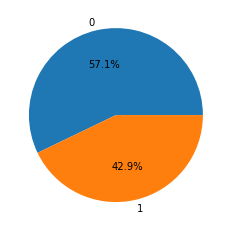

In [ ]:
df6 = getBasicDataset()

df6 = fill_missing_num_values_with_mean(df6)
df6 = fill_missing_values_binary(df6)
df6 = createBMI_cat(df6)
df6 = dealWithGCS(df6)

model = DSWorkshopModel(df6)
train_data = df6.drop('hospital_death', axis=1)
true_values = df6.hospital_death

x_train, x_test, y_train, y_test = train_test_split(train_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)

a = x_train.assign(hospital_death=y_train)
a = resampleData(a).sample(frac=1) # shuffle(resampleData(a))
x_train = a.drop('hospital_death', axis=1)
y_train = pd.Series(a['hospital_death'])

unique_labels = np.unique(a[class_prediction])
plt.pie(np.array([len(a[a[class_prediction]==label]) for label in unique_labels ]), labels = list(unique_labels), autopct='%1.1f%%')

# model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
# model.train()

# models_predictions, pred_results = model.test()
# print(pred_results)

In [ ]:
model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
model.train()

In [ ]:
models_predictions, pred_results = model.test()
print(pred_results)

          Method  Precision Score  Recall Score  F1 Score  \
0   RandomForest         0.654880      0.292483  0.404367   
1     ExtraTrees         0.751880      0.189514  0.302725   
2  XGBClassifier         0.379923      0.621605  0.471603   

   Unbalanced Accuracy Score  Balanced Accuracy Score  \
0                   0.925639                 0.638962   
1                   0.924658                 0.591803   
2                   0.879791                 0.762891   

   Positive Accuracy Score  Negative Accuracy Score Time Needed for Training  
0                  0.29248                  0.98544                   31.05s  
1                  0.18951                  0.99409                   46.92s  
2                  0.62160                  0.90418                   55.28s  


## 4. Downsampling method trial

([<matplotlib.patches.Wedge at 0x231078a9d00>,
 [Text(-0.15650172735038725, 1.088809996894015, '0'),
  Text(0.15650182929213521, -1.0888099822412611, '1')],
 [Text(-0.08536457855475667, 0.59389636194219, '54.5%'),
  Text(0.08536463415934646, -0.5938963539497788, '45.5%')])

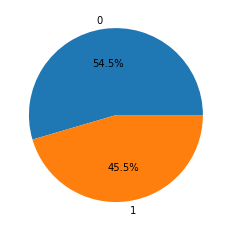

In [ ]:
df6 = getBasicDataset()

df6 = fill_missing_num_values_with_mean(df6)
df6 = fill_missing_values_binary(df6)
df6 = createBMI_cat(df6)
df6 = dealWithGCS(df6)

model = DSWorkshopModel(df6)
train_data = df6.drop('hospital_death', axis=1)
true_values = df6.hospital_death

x_train, x_test, y_train, y_test = train_test_split(train_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)

a = x_train.assign(hospital_death=y_train)
a = downsampleData(a).sample(frac=1) # shuffle(resampleData(a))
x_train = a.drop('hospital_death', axis=1)
y_train = pd.Series(a['hospital_death'])

unique_labels = np.unique(a[class_prediction])
plt.pie(np.array([len(a[a[class_prediction]==label]) for label in unique_labels ]), labels = list(unique_labels), autopct='%1.1f%%')

# model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
# model.train()

# models_predictions, pred_results = model.test()
# print(pred_results)

In [ ]:
model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
model.train()

In [ ]:
models_predictions, pred_results = model.test()
print(pred_results)

          Method  Precision Score  Recall Score  F1 Score  \
0   RandomForest         0.288878      0.766267  0.419578   
1     ExtraTrees         0.280525      0.756159  0.409231   
2  XGBClassifier         0.283916      0.769425  0.414779   

   Unbalanced Accuracy Score  Balanced Accuracy Score  \
0                   0.817042                 0.794052   
1                   0.811590                 0.786492   
2                   0.812626                 0.793066   

   Positive Accuracy Score  Negative Accuracy Score Time Needed for Training  
0                  0.76627                  0.82184                    3.48s  
1                  0.75616                  0.81683                    4.58s  
2                  0.76943                  0.81671                    9.27s  


## 5. First try to improve the model : improve dataset with improving BMI data

In [ ]:
df2 = getBasicDataset()
bmi_set = df2[['bmi','weight','height']]
bmi_set[bmi_set.isnull().any(axis=1)].head(10)

,bmi,weight,height
13848,NaN,NaN,193.0
18565,NaN,64.0,NaN
35593,NaN,NaN,NaN
13300,NaN,NaN,NaN
17122,NaN,NaN,NaN
4117,NaN,NaN,162.6
4932,NaN,NaN,177.8
88287,NaN,59.4,NaN
875,NaN,NaN,185.4
6167,NaN,NaN,157.5


Bmi is a feature which depends on weigh and heigh which already appear in the dataset. BMI has many missing value but when it is missing, also weigh or heigh is missing so we cannot compute it to fill missing values.

In [ ]:
df2 = createBMI_cat(df2)
df2 = fill_missing_num_values_with_mean(df2)
df2 = fill_missing_values_binary(df2)

In [ ]:
model = DSWorkshopModel(df2)
train_data = df2.drop('hospital_death', axis=1)
true_values = df2.hospital_death
x_train, x_test, y_train, y_test = train_test_split(train_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)
model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
model.train()
models_predictions, pred_results = model.test()
print(pred_results)

          Method  Precision Score  Recall Score  F1 Score  \
0   RandomForest         0.719682      0.228680  0.347076   
1     ExtraTrees         0.763780      0.183828  0.296334   
2  XGBClassifier         0.652672      0.324068  0.433094   

   Unbalanced Accuracy Score  Balanced Accuracy Score  \
0                   0.925748                 0.610133   
1                   0.924658                 0.589229   
2                   0.926784                 0.653890   

   Positive Accuracy Score  Negative Accuracy Score Time Needed for Training  
0                  0.22868                  0.99159                   18.39s  
1                  0.18383                  0.99463                   26.81s  
2                  0.32407                  0.98371                   34.74s  


After changing bmi, let s see if we have better results: 83.8% precision, before we had 80%.
Lets try now to improve more, by giving more meaning to our dataset

## 6.  Improve dataset with adding meaning to GCS data

This test gives a score that helps to know how much a person is in danger to die: we will try to add the result to the data because it s not given in the original data: we have only score for each component of the test: eyes, motor and verbal.
GCS - Glasgow Coma Scale : clinical scale used to reliably measure a person's level of consciousness after a brain injury. The score can be between 3 and 15 and can be separate in category:

3-8 severe
9-12 moderate
13-15 mild
=> Low score is correlated with higher risk of death.

In [ ]:
df3 = getBasicDataset()
df3 = createBMI_cat(df3)
df3 = dealWithGCS(df3)

In [ ]:
df3 = fill_missing_num_values_with_mean(df3)
df3 = fill_missing_values_binary(df3)
df3[['gcs group_Moderate','gcs group_Severe', 'gcs group_Mild', 'gcs_unable_apache']].head() #we will see new column: gcs_score and all binary column for moderate, severe,mild

,gcs group_Moderate,gcs group_Severe,gcs group_Mild,gcs_unable_apache
41655,0,0,1,0.0
4406,0,0,1,0.0
4122,0,0,1,0.0
87054,0,0,0,0.0
9167,0,0,1,0.0


In [ ]:
model = runModel(df3)
models_predictions, pred_results = model.test()
print(pred_results)

          Method  Precision Score  Recall Score  F1 Score  \
0   RandomForest         0.740260      0.252053  0.376060   
1     ExtraTrees         0.773956      0.198989  0.316583   
2  XGBClassifier         0.668311      0.342388  0.452799   

   Unbalanced Accuracy Score  Balanced Accuracy Score  \
0                   0.927820                 0.621850   
1                   0.925857                 0.596750   
2                   0.928583                 0.663169   

   Positive Accuracy Score  Negative Accuracy Score Time Needed for Training  
0                  0.25205                  0.99165                   22.11s  
1                  0.19899                  0.99451                   29.79s  
2                  0.34239                  0.98395                   32.84s  


results of adding gsc data: improve result : so we keep it

## 6. Normalize data

In [ ]:
df4 = getBasicDataset()
df4 = fill_missing_num_values_with_mean(df4)
df4 = fill_missing_values_binary(df4)
model = DSWorkshopModel(df4)
x = df4.drop('hospital_death', axis=1)

scaler = preprocessing.StandardScaler().fit(x)
x_transformed = scaler.transform(x)

true_values = df4.hospital_death
x_train, x_test, y_train, y_test = train_test_split(x_transformed, true_values, test_size=0.2, stratify=true_values, shuffle=True)
model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
model.train()

models_predictions, pred_results = model.test()
print(pred_results)

          Method  Precision Score  Recall Score  F1 Score  \
0   RandomForest         0.722433      0.240051  0.360360   
1     ExtraTrees         0.775610      0.200884  0.319117   
2  XGBClassifier         0.676166      0.329754  0.443312   

   Unbalanced Accuracy Score  Balanced Accuracy Score  \
0                   0.926457                 0.615670   
1                   0.926021                 0.597698   
2                   0.928529                 0.657419   

   Positive Accuracy Score  Negative Accuracy Score Time Needed for Training  
0                  0.24005                  0.99129                   21.77s  
1                  0.20088                  0.99451                   26.43s  
2                  0.32975                  0.98508                   30.51s  


In [ ]:
# remove features
# remove rows with too much missing values
# change distribution of the labels  (50/50)
# add data with missing values from original rows for label 1
